In [7]:
# All the required imports

import os
import random
import numpy as np
import torch
import numpy as np
from torchvision import datasets, transforms
import math
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [8]:
def set_seed(seed=27):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(seed=27)

Random seed set as 27


In [9]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [11]:
print(len(train_dataset)) 
print(len(test_dataset))

50000
10000


In [12]:
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

#### Let's have a look at the data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3277.)
  # Remove the CWD from sys.path while we load stuff.


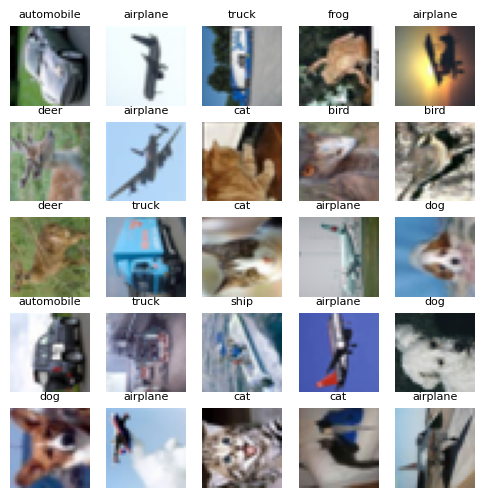

In [14]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6, 6))
cols, rows = 5,5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label], size=8)
    plt.axis("off")
    plt.imshow(img.T);
plt.show()

#### Creating the CNN model

In [15]:
class ConvNeuralNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Define the layers
    self.layers = torch.nn.Sequential(*[torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
                                       torch.nn.ReLU(),
                                       torch.nn.BatchNorm2d(32),
                                       torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                       torch.nn.Dropout(0.25),
                                       torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                       torch.nn.ReLU(),
                                       torch.nn.BatchNorm2d(64),
                                       torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                       torch.nn.Dropout(0.25),
                                       torch.nn.Flatten(),
                                       torch.nn.Linear(1600, 1024),
                                       torch.nn.Dropout(0.25),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(1024, 512),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(512, 10)])
    # Define the corresponding masks if the layer has weight
    self.masks = torch.nn.ParameterList([torch.nn.Parameter(torch.Tensor(torch.ones(self.layers[i].weight.data.shape)), requires_grad=False) \
                                         for i in range(len(self.layers)) \
                                         if hasattr(self.layers[i], 'weight')])
    
  def forward(self, x):
    # First multiply each layer's weights with its corresponding mask
    with torch.no_grad():
      j = 0
      for i in range(len(self.layers)):
        if hasattr(self.layers[i], 'weight'):
          self.layers[i].weight.copy_(self.layers[i].weight.data * self.masks[j])
          j += 1
        else:
          pass
    
    return self.layers(x)

In [16]:
model = ConvNeuralNet().to(device)
model

ConvNeuralNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1600, out_features=1024, bias=True)
    (16): Dropout(p=0.25, inplace=False)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, bias=True)
  

In [17]:
# Check which layer has weight

for i in range(len(model.layers)):
  print(f"({i}): {model.layers[i]}")
  if hasattr(model.layers[i], 'weight'):
    print(model.layers[i].weight.data.shape)
  else:
    print("No weight")
  print("----------------------------------------")

(0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
----------------------------------------
(1): ReLU()
No weight
----------------------------------------
(2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 32, 3, 3])
----------------------------------------
(3): ReLU()
No weight
----------------------------------------
(4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([32])
----------------------------------------
(5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
No weight
----------------------------------------
(6): Dropout(p=0.25, inplace=False)
No weight
----------------------------------------
(7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
torch.Size([64, 32, 3, 3])
----------------------------------------
(8): ReLU()
No weight
----------------------------------------
(9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
torch.Size([64, 64, 3, 3])
-

In [18]:
def train_model(epochs, dataloader, device, model, optimizer, loss_function):
    # Set model to training mode in order to unfreeze all layers and allow gradient propagation
    model.train()
    # These two lists will be used to store average loss and accuracy for each epoch
    total_loss, acc = list(), list()
    # Now write out the training procedure
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        # Each batch produces a loss, predictions and target
        batch_loss, batch_preds, batch_target = 0, list(), list()
        # For each batch, train the model
        for x, y in tqdm(dataloader, total=len(dataloader)):
            # Make sure that data is on the same device as the model
            x, y = x.to(device), y.to(device)
            # Remove all previous gradients
            optimizer.zero_grad()
            # Get predictions by performing a forward pass
            preds = model.forward(x.float())
            # Calculate error
            loss = loss_function(preds, y.to(torch.int64))
            # Calculate all the gradients for each layer
            loss.backward()
            # Finall, update the weights
            optimizer.step()
            # Save the loss
            batch_loss+= loss.item()
            # Save the predictions and target
            batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
            batch_target.extend(y.cpu().detach().numpy())
        # Calculate average loss
        total_loss.append(batch_loss/len(dataloader))
        # Calculate accuracy for this epoch
        acc.append(accuracy_score(batch_target, batch_preds))
        print("Loss:", total_loss[-1], "\tAcc:", acc[-1])
    return model, total_loss, acc

def test_model(dataloader, device, model):
    # Set model to eval mode in order to freeze all layers so that no parameter gets updated during testing
    model.eval()
    # Each batch produces a loss, predictions and target
    batch_preds, batch_target = list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader, total=len(dataloader)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        preds = model.forward(x.float())
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.cpu().detach().numpy())
    return accuracy_score(batch_target, batch_preds)

## Getting the baseline performance

In [21]:
epochs = 25
baseline_model = ConvNeuralNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.003)
baseline_model, _, _ = train_model(epochs, dataloader_train, device, baseline_model, optimizer, loss_function)

Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6781390333662227 	Acc: 0.40244
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2549172238427766 	Acc: 0.55116
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0625112068896392 	Acc: 0.62228
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9315718546205637 	Acc: 0.66938
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.827976330202453 	Acc: 0.708
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7397562910099419 	Acc: 0.73904
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6691056532519204 	Acc: 0.76386
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6153499870275965 	Acc: 0.78084
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5666543522051403 	Acc: 0.80118
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5308707800446725 	Acc: 0.81098
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4891019399677004 	Acc: 0.82624
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4636515856397395 	Acc: 0.83516
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42971755138465334 	Acc: 0.8481
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40854259625989564 	Acc: 0.8563
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3748029665071137 	Acc: 0.86756
Epoch: 16


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3637528772256812 	Acc: 0.87332
Epoch: 17


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34180101554612724 	Acc: 0.87912
Epoch: 18


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33046278114221533 	Acc: 0.88186
Epoch: 19


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31545282778691275 	Acc: 0.88916
Epoch: 20


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3024374400170482 	Acc: 0.89256
Epoch: 21


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27757573188567647 	Acc: 0.90262
Epoch: 22


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27463948513780323 	Acc: 0.90576
Epoch: 23


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.26573009454474156 	Acc: 0.90666
Epoch: 24


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24765055930736113 	Acc: 0.91284
Epoch: 25


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24467931885500344 	Acc: 0.91558


In [22]:
# Finding the test accuracy of our baseline model

test_accuracy = test_model(dataloader_val, device, baseline_model)
print(f"Validation accuracy of the baseline model is {test_accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy of the baseline model is 0.751


## Now performing Lottery Ticket pruning

In [51]:
def lth_pruning(rounds, epochs, sparsity):
    # Set the number of epochs to be used
    epochs = epochs
    # Set the number of rounds
    rounds = rounds
    # Set the sparsity level for each layer
    sparsity = sparsity
    # Create the model
    model = ConvNeuralNet().to(device)
    # Define Loss
    loss_function = torch.nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

    # First save the model weights that have been initialized
    init_weights = [model.layers[i].weight.data.to(device) for i in range(len(model.layers)) if hasattr(model.layers[i], 'weight')]

    for round_ in range(rounds):
        print("\n\n\nROUND", round_+1, "Started\n----------------------")
        # First train the model for some epochs
        model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
        if round_ == 0:
            print("Test Accuracy before pruning:", test_model(dataloader_val, device, model))
        else:
            print("Test Accuracy after pruning and retraining:", test_model(dataloader_val, device, model))
        with torch.no_grad():
            # Now prune the model weights
            j = 0
            for i in range(len(model.layers)):
              if hasattr(model.layers[i], 'weight'):
                  flatten_size = model.layers[i].weight.data.flatten().shape[0]
                  # Lottery Ticket Style Pruning
                  indices = torch.argsort(torch.reshape(torch.abs(model.layers[i].weight.data), (1, flatten_size)).squeeze())
                  # Since we already have the indices to prune, first reset the parameters
                  model.layers[i].weight.copy_(init_weights[j])
                  # Now prune
                  model.masks[j] = torch.reshape(model.masks[j], (1, flatten_size)).squeeze()
                  val = ((sparsity*100)**((round_+1)/rounds))/100
                  model.masks[j][indices[:math.ceil(val * flatten_size)]] = 0
                  model.masks[j] = model.masks[j].view(*model.layers[i].weight.data.shape)
                  j += 1
        print("Test Accuracy after pruning but no retraining:", test_model(dataloader_val, device, model))

### Sparsity : 0.1

In [52]:
lth_pruning(5, 5, 0.1)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.5562300390126753 	Acc: 0.4347
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1548144659217523 	Acc: 0.58842
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9666622463537722 	Acc: 0.65986
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.823594622466029 	Acc: 0.70904
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7246799888659496 	Acc: 0.74302


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.6764


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6586



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.657423844142836 	Acc: 0.76698
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5948619295139702 	Acc: 0.7886
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5385773945219663 	Acc: 0.80884
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4912254116973098 	Acc: 0.82528
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.453286272530653 	Acc: 0.83968


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7624


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7622



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4156471238452561 	Acc: 0.85288
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38963352417459296 	Acc: 0.86296
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3561963128800295 	Acc: 0.87288
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3378188798622209 	Acc: 0.882
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31668785746608463 	Acc: 0.88846


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.734


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7241



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30980246863803085 	Acc: 0.88838
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3008208008749144 	Acc: 0.8935
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.281657269566643 	Acc: 0.90192
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.25426426028110544 	Acc: 0.91176
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24612018222711524 	Acc: 0.91412


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7607


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7381



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2627781159719642 	Acc: 0.90778
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24278662794706773 	Acc: 0.91496
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22784230888498072 	Acc: 0.92018
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21785053549980632 	Acc: 0.92474
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.20675010462196505 	Acc: 0.92742


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7762


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7546


### Sparsity : 0.2

In [53]:
lth_pruning(5, 5, 0.2)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6596265532532517 	Acc: 0.405
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.195182471859212 	Acc: 0.57418
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9870150265645008 	Acc: 0.65036
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8584289325743305 	Acc: 0.6997
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7557084353602662 	Acc: 0.73494


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7145


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7113



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6843164204334726 	Acc: 0.75926
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.619751581123897 	Acc: 0.78134
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5740662113744386 	Acc: 0.79488
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5275408579986922 	Acc: 0.81254
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.48109367733099023 	Acc: 0.82884


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7569


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7227



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4598380798587994 	Acc: 0.83718
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.43400782559599194 	Acc: 0.84666
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39991866234613926 	Acc: 0.85976
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38443044192936954 	Acc: 0.86344
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3579507947576289 	Acc: 0.87388


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7685


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7666



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3315741511023774 	Acc: 0.88152
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3207356650002149 	Acc: 0.88716
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3047099980164547 	Acc: 0.89246
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2914087311649809 	Acc: 0.8987
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2749577163129437 	Acc: 0.90212


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7879


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7746



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30083624334359654 	Acc: 0.89344
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27759675453512034 	Acc: 0.90188
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.26156734964069056 	Acc: 0.90894
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24770062492818248 	Acc: 0.91444
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24519010450767012 	Acc: 0.91524


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7771


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7288


### Sparsity : 0.3

In [54]:
lth_pruning(5, 5, 0.3)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.617305992817392 	Acc: 0.41484
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.21705477213373 	Acc: 0.56608
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0081947372884166 	Acc: 0.6437
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8551497872994871 	Acc: 0.69974
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7558894339872866 	Acc: 0.73622


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7336


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7205



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.668035585053113 	Acc: 0.76552
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.606218873238077 	Acc: 0.78688
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5506338285548347 	Acc: 0.80614
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5049069317019715 	Acc: 0.82176
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4606860185764274 	Acc: 0.83686


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7589


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.75



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4338739496104571 	Acc: 0.84532
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39830245685820675 	Acc: 0.8576
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.37952883724047215 	Acc: 0.86424
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34095048387439886 	Acc: 0.87982
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3296908117374595 	Acc: 0.88216


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7602


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7507



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32890961927418805 	Acc: 0.88308
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2974376450387799 	Acc: 0.89514
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2809773905544865 	Acc: 0.90154
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2645614734109567 	Acc: 0.9066
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2547436192327616 	Acc: 0.91102


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7728


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7282



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30760094325761406 	Acc: 0.89274
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2645786165886996 	Acc: 0.90646
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24768691008188287 	Acc: 0.9135
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24260973458995624 	Acc: 0.91574
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22754487957881422 	Acc: 0.92104


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7808


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6968


### Sparsity : 0.4

In [55]:
lth_pruning(5, 5, 0.4)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.7336351640370427 	Acc: 0.3753
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2778231574564565 	Acc: 0.54194
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0866354971515888 	Acc: 0.61366
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9455723537474262 	Acc: 0.66596
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8372537408556256 	Acc: 0.70634


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.6766


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6728



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7607813392366681 	Acc: 0.73364
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6870286726221746 	Acc: 0.7588
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6246848221944303 	Acc: 0.77926
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.578989139320899 	Acc: 0.79438
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5372075648332129 	Acc: 0.81062


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7264


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7226



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5130560176104916 	Acc: 0.81964
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.46721313802563413 	Acc: 0.83438
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42968471074590875 	Acc: 0.84944
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4110361176485918 	Acc: 0.85624
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38460629114082884 	Acc: 0.86162


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7529


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7275



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3908097035422617 	Acc: 0.8623
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3487757225425876 	Acc: 0.87552
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.334807284024297 	Acc: 0.88292
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3209577474971207 	Acc: 0.8866
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3024457083368788 	Acc: 0.89414


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7552


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6683



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4111991323986832 	Acc: 0.854
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35518297887578304 	Acc: 0.87498
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32742554055792944 	Acc: 0.88516
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3159462205913602 	Acc: 0.88786
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2993384047734494 	Acc: 0.8939


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7533


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6272


### Sparsity : 0.5

In [56]:
lth_pruning(5, 5, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6638417499405997 	Acc: 0.4053
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2355910709926061 	Acc: 0.55476
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.032420539734315 	Acc: 0.63506
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8920483035700661 	Acc: 0.68652
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7824290516425152 	Acc: 0.72412


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7004


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6978



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7018946366650718 	Acc: 0.75236
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.628744859780584 	Acc: 0.77862
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5768491382501564 	Acc: 0.7979
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5285481320960181 	Acc: 0.8144
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4844894293619662 	Acc: 0.82858


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.757


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7551



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4549531142930595 	Acc: 0.83902
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4163716474966127 	Acc: 0.85188
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3843203408985722 	Acc: 0.86316
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36800385129695035 	Acc: 0.87086
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34492975321351266 	Acc: 0.8782


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7352


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7378



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3596994581879402 	Acc: 0.87422
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3187124341422198 	Acc: 0.88764
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30604146709855723 	Acc: 0.89256
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.28799547391886615 	Acc: 0.89676
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27352894918651 	Acc: 0.90422


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7721


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.652



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40565142734926574 	Acc: 0.85856
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3338334537586387 	Acc: 0.8834
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30343291148239254 	Acc: 0.8945
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2961597906387582 	Acc: 0.89568
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2769763793568222 	Acc: 0.90382


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7754


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4385


## Now performing Random pruning

In [57]:
def random_pruning(rounds, epochs, sparsity):
    # Set the number of epochs to be used
    epochs = epochs
    # Set the number of rounds
    rounds = rounds
    # Set the sparsity level for each layer
    sparsity = sparsity
    # Create the model
    model = ConvNeuralNet().to(device)
    # Define Loss
    loss_function = torch.nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

    # First save the model weights that have been initialized
    init_weights = [model.layers[i].weight.data.to(device) for i in range(len(model.layers)) if hasattr(model.layers[i], 'weight')]

    for round_ in range(rounds):
        print("\n\n\nROUND", round_+1, "Started\n----------------------")
        # First train the model for some epochs
        model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
        if round_ == 0:
            print("Test Accuracy before pruning:", test_model(dataloader_val, device, model))
        else:
            print("Test Accuracy after pruning and retraining:", test_model(dataloader_val, device, model))
        with torch.no_grad():
            # Now prune the model weights
            j = 0
            for i in range(len(model.layers)):
              if hasattr(model.layers[i], 'weight'):
                  flatten_size = model.layers[i].weight.data.flatten().shape[0]
                  # Random pruning
                  indices = np.random.randint(0, flatten_size, flatten_size)
                  # Since we already have the indices to prune, first reset the parameters
                  model.layers[i].weight.copy_(init_weights[j])
                  # Now prune
                  model.masks[j] = torch.reshape(model.masks[j], (1, flatten_size)).squeeze()
                  val = ((sparsity*100)**((round_+1)/rounds))/100
                  model.masks[j][indices[:math.ceil(val * flatten_size)]] = 0
                  model.masks[j] = model.masks[j].view(*model.layers[i].weight.data.shape)
                  j += 1
        print("Test Accuracy after pruning but no retraining:", test_model(dataloader_val, device, model))

### Sparsity : 0.1

In [58]:
random_pruning(5, 5, 0.1)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.7477825101541014 	Acc: 0.37198
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.3066025461469377 	Acc: 0.53022
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0934072836321227 	Acc: 0.61282
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9551445166675412 	Acc: 0.66198
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8577859456441841 	Acc: 0.69616


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.6896


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4866



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7994256804184038 	Acc: 0.7202
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7091196830175361 	Acc: 0.75082
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6369646909285565 	Acc: 0.77512
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5876412999873258 	Acc: 0.79284
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5425784779446465 	Acc: 0.8086


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7352


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4136



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5628581162618131 	Acc: 0.80188
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.48745156611715046 	Acc: 0.82698
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.45843011262465494 	Acc: 0.83648
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42629687457668536 	Acc: 0.84722
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4075007645451293 	Acc: 0.8553


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7617


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.503



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.437899938043283 	Acc: 0.84514
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39161824237327186 	Acc: 0.86228
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36498418419944995 	Acc: 0.87048
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3372219156245796 	Acc: 0.87912
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31588911690882276 	Acc: 0.88842


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7666


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3712



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4318867581231253 	Acc: 0.84706
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3791566530660707 	Acc: 0.86654
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3465477288985739 	Acc: 0.87694
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31878762327286664 	Acc: 0.8863
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3070681397708095 	Acc: 0.89138


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7672


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4801


### Sparsity : 0.2

In [59]:
random_pruning(5, 5, 0.2)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.7261092431691227 	Acc: 0.38272
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.284741952711222 	Acc: 0.53824
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0656528849991 	Acc: 0.62234
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9277977919091984 	Acc: 0.67376
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.811597963376921 	Acc: 0.71316


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7135


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6529



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7452926331636857 	Acc: 0.73888
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6662047912879866 	Acc: 0.76744
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6202881695056448 	Acc: 0.78294
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5603053381248396 	Acc: 0.8034
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5207862051165834 	Acc: 0.81476


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7453


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5723



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5307597843359928 	Acc: 0.81218
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4740919957355577 	Acc: 0.83136
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4404979287361612 	Acc: 0.84422
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41330176257357304 	Acc: 0.85236
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39793973035958347 	Acc: 0.85884


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7642


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6196



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4486802405848795 	Acc: 0.84138
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3958149759136901 	Acc: 0.86152
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.37008476105271554 	Acc: 0.86968
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3559527284636789 	Acc: 0.87324
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32562636143090773 	Acc: 0.8852


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7709


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4737



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5070864330140912 	Acc: 0.8216
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42194657027721405 	Acc: 0.85086
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39198668331516034 	Acc: 0.86196
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36830371800734074 	Acc: 0.87026
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.338496133685112 	Acc: 0.87942


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7415


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1536


### Sparsity : 0.3

In [60]:
random_pruning(5, 5, 0.3)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6883317451087796 	Acc: 0.39308
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2530061979683078 	Acc: 0.55324
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.043241449156586 	Acc: 0.63148
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8969135363491214 	Acc: 0.68394
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7791900470548746 	Acc: 0.72724


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.6964


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6387



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7065642135483878 	Acc: 0.75274
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6268311939677413 	Acc: 0.7797
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5675806658608573 	Acc: 0.79728
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5254663974046707 	Acc: 0.81484
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4830956066749534 	Acc: 0.82816


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7573


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6376



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.503678240034045 	Acc: 0.82198
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4379776010707933 	Acc: 0.8446
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40915779678189024 	Acc: 0.85582
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3722906839482638 	Acc: 0.86746
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35092501099012335 	Acc: 0.8766


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7648


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3856



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4448458214803618 	Acc: 0.84446
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3717170442853655 	Acc: 0.86936
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3377039499428807 	Acc: 0.88068
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3184020053975436 	Acc: 0.88662
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3009938790786023 	Acc: 0.89298


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.757


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1668



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5102883102942486 	Acc: 0.8205
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3964174560138157 	Acc: 0.86086
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3590004410670728 	Acc: 0.87334
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33760211723191397 	Acc: 0.88208
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3166396762339436 	Acc: 0.88898


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7632


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.111


### Sparsity : 0.4

In [61]:
random_pruning(5, 5, 0.4)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6547650244771217 	Acc: 0.40888
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.227318672501311 	Acc: 0.56246
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0294758458526767 	Acc: 0.63494
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8948250710964203 	Acc: 0.6843
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7963088106135933 	Acc: 0.7162


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.6608


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6227



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7259466477802822 	Acc: 0.74498
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.65027810602772 	Acc: 0.7685
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6001630942432248 	Acc: 0.78642
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5501880232168703 	Acc: 0.80522
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5022604468525672 	Acc: 0.82128


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7492


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3324



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5439186914234745 	Acc: 0.8084
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.47573185362377945 	Acc: 0.83054
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.44816705949452457 	Acc: 0.84068
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4109852712373344 	Acc: 0.85426
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.388531680922119 	Acc: 0.86358


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7523


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4717



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5240197601367016 	Acc: 0.81486
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.44915493410460805 	Acc: 0.83962
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41619131273152876 	Acc: 0.85132
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3823139494170948 	Acc: 0.86248
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3709713673713256 	Acc: 0.86868


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.762


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1585



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.740791568950731 	Acc: 0.741
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5686249799874364 	Acc: 0.79862
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5266272924384292 	Acc: 0.81384
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.49434628413648024 	Acc: 0.82688
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4642753625402645 	Acc: 0.83478


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7537


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1827


### Sparsity : 0.5

In [62]:
random_pruning(5, 5, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.5887899252833153 	Acc: 0.42866
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1677472810355984 	Acc: 0.58508
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9723937468869346 	Acc: 0.65478
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8485719354785218 	Acc: 0.70134
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.744140590940203 	Acc: 0.73818


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7132


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5614



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6896399460276779 	Acc: 0.75564
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6188915232006384 	Acc: 0.77948
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.566932139652116 	Acc: 0.79828
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5224662277163291 	Acc: 0.81494
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4791485615530793 	Acc: 0.82802


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7577


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5915



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4840117315856778 	Acc: 0.82838
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4343522373510867 	Acc: 0.84606
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.402742726462228 	Acc: 0.85656
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.37876986727422596 	Acc: 0.86434
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3568961161131762 	Acc: 0.87444


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7699


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.414



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.47522221231947137 	Acc: 0.83284
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38870509820325033 	Acc: 0.8629
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3609081865573416 	Acc: 0.8739
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3374450577765095 	Acc: 0.88178
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32206027407427223 	Acc: 0.88646


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7725


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1069



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7482258342966741 	Acc: 0.73756
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5447438341014239 	Acc: 0.80758
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.48277423850127626 	Acc: 0.82886
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.439615859669082 	Acc: 0.8455
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4128131601883441 	Acc: 0.85374


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7771


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1002


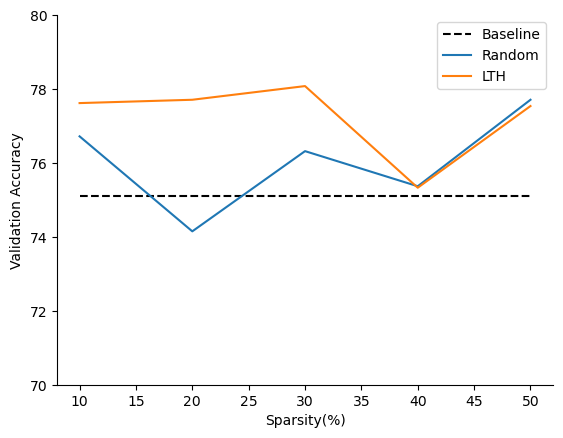

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=[10, 20, 30, 40, 50], y=[75.10, 75.10, 75.10, 75.10, 75.10], linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[76.72, 74.15, 76.32, 75.37, 77.71], label="Random")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[77.62, 77.71, 78.08, 75.33, 77.54], label="LTH")
plt.ylim(70, 80)
plt.xlabel("Sparsity(%)")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.show()

The LTH performance is always staying above the baseline performance. Hence our hypothesis is correct.

## Effect  of  the  number  of  rounds  on  model performance

### Sparsity = 0.5 (fixed)

#### Lottery Ticket style pruning

##### Round = 1

In [47]:
lth_pruning(1, 30, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6908026398444662 	Acc: 0.39348
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2466974453050264 	Acc: 0.55374
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0472319442398694 	Acc: 0.62852
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9141626132994282 	Acc: 0.67594
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8114443500431217 	Acc: 0.71494
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7305014559200832 	Acc: 0.7416
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6701924873858082 	Acc: 0.7647
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6175800805189171 	Acc: 0.78034
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.572451112829909 	Acc: 0.79766
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5368710148091219 	Acc: 0.80838
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4977307845743335 	Acc: 0.82496
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.46511875397088576 	Acc: 0.8344
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.43388890733524244 	Acc: 0.84664
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4133205222232001 	Acc: 0.8544
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3866076277835028 	Acc: 0.86398
Epoch: 16


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3767638759953635 	Acc: 0.86632
Epoch: 17


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35106876005931775 	Acc: 0.87596
Epoch: 18


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3349379252414314 	Acc: 0.88212
Epoch: 19


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31543935470435086 	Acc: 0.88934
Epoch: 20


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2990286894598786 	Acc: 0.89602
Epoch: 21


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2884616871573487 	Acc: 0.8991
Epoch: 22


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2786722656111328 	Acc: 0.90198
Epoch: 23


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2670253433135091 	Acc: 0.90652
Epoch: 24


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2591133630093263 	Acc: 0.9104
Epoch: 25


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24615325915570163 	Acc: 0.91356
Epoch: 26


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2426344921090165 	Acc: 0.91762
Epoch: 27


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.23192847550523524 	Acc: 0.91822
Epoch: 28


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2155122621631136 	Acc: 0.925
Epoch: 29


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22144693805246937 	Acc: 0.9241
Epoch: 30


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21494719142816504 	Acc: 0.92482


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7722


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.0908


##### Rounds = 2

In [48]:
lth_pruning(2, 15, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.690534377584652 	Acc: 0.39192
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2358325050801646 	Acc: 0.55858
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0314712427100357 	Acc: 0.63368
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8685670677496462 	Acc: 0.69392
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7670715299187875 	Acc: 0.73248
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6831487709162186 	Acc: 0.76088
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6074252311064272 	Acc: 0.7874
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5504117875683064 	Acc: 0.8051
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5159274020365306 	Acc: 0.81938
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4701973135982241 	Acc: 0.83572
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4249326191386398 	Acc: 0.8489
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3989601232567612 	Acc: 0.85928
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3728200151604049 	Acc: 0.86718
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34702399068949175 	Acc: 0.87754
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32479677121249995 	Acc: 0.88526


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7729


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6482



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3967804200187021 	Acc: 0.86044
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.347029055563771 	Acc: 0.8783
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3224351378727932 	Acc: 0.88652
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.29946363519649116 	Acc: 0.89446
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.28031929627973207 	Acc: 0.90162
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2718630755434231 	Acc: 0.904
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2531708834730849 	Acc: 0.9116
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24869185579674585 	Acc: 0.91252
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2284718981506873 	Acc: 0.92096
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21954674152087192 	Acc: 0.92382
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22653338449950122 	Acc: 0.92144
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21097982492373915 	Acc: 0.92758
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.1930319143041056 	Acc: 0.93274
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.1946772721653082 	Acc: 0.9326
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.17846406015510463 	Acc: 0.93906


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7915


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1002


##### Rounds = 3

In [49]:
lth_pruning(3, 10, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6250602931392437 	Acc: 0.41924
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1878458407460426 	Acc: 0.57568
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.995982710804258 	Acc: 0.64598
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8452743571631762 	Acc: 0.7009
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7412913234866395 	Acc: 0.7378
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6710482963493892 	Acc: 0.76284
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5943984924530497 	Acc: 0.78864
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5347304830745775 	Acc: 0.81126
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.49595543772590406 	Acc: 0.82444
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4536900036797232 	Acc: 0.83902


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7523


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6209



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.48357903774903743 	Acc: 0.82834
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.423390405518668 	Acc: 0.84918
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39019156688330126 	Acc: 0.86196
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36470860273254163 	Acc: 0.86982
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3448704888626021 	Acc: 0.87786
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32280566315261683 	Acc: 0.88536
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3032672015988097 	Acc: 0.89264
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2895475975712951 	Acc: 0.8997
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.26767389309041356 	Acc: 0.90518
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2585659130495422 	Acc: 0.9093


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7774


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4166



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42343376637721547 	Acc: 0.8527
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34025465970744895 	Acc: 0.87962
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30924459926936093 	Acc: 0.8915
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.29264879606816235 	Acc: 0.89756
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.28146155482652235 	Acc: 0.9005
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.26649175675547854 	Acc: 0.90624
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24954716116189957 	Acc: 0.91212
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24134134197113466 	Acc: 0.91308
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22448139318398067 	Acc: 0.922
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22508174363447694 	Acc: 0.92188


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7859


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1012


##### Rounds = 4

In [50]:
lth_pruning(4, 7, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6223224802893035 	Acc: 0.41598
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1798610881883271 	Acc: 0.57914
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9783541000619227 	Acc: 0.6582
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8267714533270621 	Acc: 0.70898
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7258245750349395 	Acc: 0.74516
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.657516675031915 	Acc: 0.76652
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.592193926475486 	Acc: 0.79002


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7175


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5987



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5643782646072154 	Acc: 0.79772
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5179545198168073 	Acc: 0.81658
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4644676188425142 	Acc: 0.83532
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.43442782638024313 	Acc: 0.84624
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4027044888661832 	Acc: 0.85704
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38007979611961207 	Acc: 0.86492
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.34641938519721127 	Acc: 0.87498


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7684


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6256



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4420372119971684 	Acc: 0.84402
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3710800138663273 	Acc: 0.8692
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3349935819908064 	Acc: 0.88118
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32269791407244547 	Acc: 0.8853
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3014383148782107 	Acc: 0.89502
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2900554096820403 	Acc: 0.89748
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2614707771916779 	Acc: 0.90818


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.779


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3682



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5921235932987563 	Acc: 0.79292
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4585986076569071 	Acc: 0.84048
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41326315883471043 	Acc: 0.85406
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3835232303458817 	Acc: 0.86372
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35632339728121853 	Acc: 0.87392
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3365341875017906 	Acc: 0.88118
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3229521362453091 	Acc: 0.8851


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7672


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1001


##### Rounds = 5

In [51]:
lth_pruning(5, 6, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6046201586723328 	Acc: 0.41988
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1708624581901395 	Acc: 0.58376
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9711238151910354 	Acc: 0.655
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8384358110476513 	Acc: 0.70272
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7353070706737285 	Acc: 0.74018
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6565124118814663 	Acc: 0.76796


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7052


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.686



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6021499977428086 	Acc: 0.78716
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5468098156306208 	Acc: 0.8071
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.501609957035707 	Acc: 0.8202
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4556249294962202 	Acc: 0.83666
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41930036915808305 	Acc: 0.85174
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3869939850909369 	Acc: 0.86218


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7332


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3649



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.42839065407003674 	Acc: 0.84944
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36982492920087306 	Acc: 0.86968
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3428020830057105 	Acc: 0.87938
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3198529294863039 	Acc: 0.8876
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30575819936942084 	Acc: 0.89258
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27813746582488624 	Acc: 0.90246


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7715


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.4329



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4300633148879421 	Acc: 0.84918
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.354170916031818 	Acc: 0.87448
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3146178258620963 	Acc: 0.88876
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3001622898238046 	Acc: 0.8948
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2831686872000597 	Acc: 0.90018
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2629300691947645 	Acc: 0.90824


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7801


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.195



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6928816681005516 	Acc: 0.75862
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5168066149463459 	Acc: 0.81738
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4610786444070388 	Acc: 0.83752
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41673259376263133 	Acc: 0.85314
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39359140000781234 	Acc: 0.86076
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36868966963826394 	Acc: 0.87012


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.745


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1389


#### Random pruning

##### Round(s) = 1

In [54]:
random_pruning(1, 30, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6444968386572234 	Acc: 0.40762
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.203191142909381 	Acc: 0.57252
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0095049988250344 	Acc: 0.64444
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8731022744762654 	Acc: 0.69384
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7621033003135603 	Acc: 0.7336
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6790381694326595 	Acc: 0.76
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6168928718080327 	Acc: 0.78194
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5595168069917329 	Acc: 0.80172
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.505322197566227 	Acc: 0.82044
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.465988710826757 	Acc: 0.83514
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4222734619160088 	Acc: 0.84846
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3957419869851093 	Acc: 0.8605
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36362888785649317 	Acc: 0.87158
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33813378062783456 	Acc: 0.8802
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3076453012775402 	Acc: 0.8918
Epoch: 16


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.29408463166684523 	Acc: 0.896
Epoch: 17


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27605576007341853 	Acc: 0.90386
Epoch: 18


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2556995761637785 	Acc: 0.91214
Epoch: 19


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2397029133779662 	Acc: 0.91558
Epoch: 20


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.23218856356581863 	Acc: 0.91988
Epoch: 21


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21903044715219613 	Acc: 0.92494
Epoch: 22


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21202979692999196 	Acc: 0.92668
Epoch: 23


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.19704526814879203 	Acc: 0.93274
Epoch: 24


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.19020476374699144 	Acc: 0.93396
Epoch: 25


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.1815581665355332 	Acc: 0.93712
Epoch: 26


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.18566822367055075 	Acc: 0.93582
Epoch: 27


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.17212122473485617 	Acc: 0.94118
Epoch: 28


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.16072383408947866 	Acc: 0.94556
Epoch: 29


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.16066524720921807 	Acc: 0.9444
Epoch: 30


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.15760171930400693 	Acc: 0.94592


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7853


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1


##### Round(s) = 2

In [23]:
random_pruning(2, 15, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.5895960635068465 	Acc: 0.42764
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1574746990690425 	Acc: 0.5872
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9610820637673748 	Acc: 0.66158
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8250274585217846 	Acc: 0.71158
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7326256316535327 	Acc: 0.74376
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6610760044078438 	Acc: 0.76878
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6051626013857978 	Acc: 0.78582
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5492712764107451 	Acc: 0.80574
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5144352657454354 	Acc: 0.817
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.47604446052288524 	Acc: 0.83184
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.44119299035899495 	Acc: 0.8436
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.41168050741662787 	Acc: 0.85394
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39090063012376125 	Acc: 0.86072
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3618805986277911 	Acc: 0.87284
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3426743794460686 	Acc: 0.8798


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7597


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5416



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40566097868948564 	Acc: 0.85792
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35018011304188745 	Acc: 0.87688
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32802531700961446 	Acc: 0.88388
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30604985949336266 	Acc: 0.8915
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.292773539162412 	Acc: 0.89686
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2735592316912145 	Acc: 0.90398
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2674493695400199 	Acc: 0.9056
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2548333981207439 	Acc: 0.91112
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24444392825267752 	Acc: 0.91332
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.24290255761268187 	Acc: 0.91508
Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.23404976619141443 	Acc: 0.91728
Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.21609338205687853 	Acc: 0.9251
Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.20796748509212415 	Acc: 0.92726
Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.206322830398472 	Acc: 0.92736
Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.20046769599525296 	Acc: 0.9313


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7814


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1


##### Round(s) = 3

In [24]:
random_pruning(3, 10, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.665566196247023 	Acc: 0.40102
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.18555051879007 	Acc: 0.57804
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.9994888907792617 	Acc: 0.64526
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8641248406196127 	Acc: 0.69504
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7736709409830521 	Acc: 0.72896
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6806558455739703 	Acc: 0.7596
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6161858454650763 	Acc: 0.78266
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5519658533894286 	Acc: 0.80404
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4984909140942048 	Acc: 0.8244
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.469534766917326 	Acc: 0.83448


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7383


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5967



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4818284143598712 	Acc: 0.83052
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4250232115083811 	Acc: 0.84978
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3863837271928787 	Acc: 0.86292
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3548673926567545 	Acc: 0.87376
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33347869907714883 	Acc: 0.8818
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30760578871989736 	Acc: 0.89066
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.28997280053338226 	Acc: 0.8969
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2784401411000563 	Acc: 0.90182
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.26215084094782265 	Acc: 0.90954
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.25008448274159917 	Acc: 0.91336


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7645


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.2913



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.46148405360932254 	Acc: 0.8382
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3627976799497799 	Acc: 0.87308
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.32509633549013917 	Acc: 0.88686
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.308385075659168 	Acc: 0.89244
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2857360322864688 	Acc: 0.89978
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.27102273048795 	Acc: 0.9041
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.25262920695300006 	Acc: 0.91176
Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2459233611518023 	Acc: 0.91548
Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.23466716417852712 	Acc: 0.9181
Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.22681794954197748 	Acc: 0.9227


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7664


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1


##### Round(s) = 4

In [25]:
random_pruning(4, 7, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6796785130792735 	Acc: 0.39736
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2194569700834703 	Acc: 0.56574
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0185894874893888 	Acc: 0.63844
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.8753675404860048 	Acc: 0.69268
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7587697828302578 	Acc: 0.7318
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6778752736899317 	Acc: 0.76054
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6077751486885304 	Acc: 0.78354


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7175


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6216



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5706475355795452 	Acc: 0.79798
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.520660682904477 	Acc: 0.81724
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.48048077827813673 	Acc: 0.8304
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4361105162878426 	Acc: 0.8449
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40251406266981243 	Acc: 0.85768
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.37736453693740224 	Acc: 0.8657
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.35759557327445674 	Acc: 0.87274


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7635


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.3408



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.437754822932944 	Acc: 0.84532
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3630148950888186 	Acc: 0.87194
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33508957192605854 	Acc: 0.88194
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31098816969564985 	Acc: 0.89042
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.29483654927842473 	Acc: 0.89556
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2896939038622136 	Acc: 0.89702
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.2673600965312549 	Acc: 0.90558


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7747


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1483



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5697369730594207 	Acc: 0.80052
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.430824731381572 	Acc: 0.84524
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3934044868362193 	Acc: 0.8606
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.36543331523330846 	Acc: 0.87084
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3390880997995941 	Acc: 0.88046
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3173242615801947 	Acc: 0.88892
Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30367856244651636 	Acc: 0.89254


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.773


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1378


##### Round(s) = 5

In [26]:
random_pruning(5, 6, 0.5)




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6345584647996085 	Acc: 0.41286
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2136194961411613 	Acc: 0.56718
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.0166005869300998 	Acc: 0.64272
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.87024822952796 	Acc: 0.69518
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.7620292202550538 	Acc: 0.73418
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6890113244251329 	Acc: 0.75904


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.7346


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.7216



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6305501667820678 	Acc: 0.77718
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5738830958702126 	Acc: 0.79796
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5288428363143182 	Acc: 0.81234
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4795229066999591 	Acc: 0.82984
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.43595530366411017 	Acc: 0.84622
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40911832968799433 	Acc: 0.85508


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7718


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.6626



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4328447008619503 	Acc: 0.84716
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.39379736355372835 	Acc: 0.862
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.37067491211453263 	Acc: 0.86916
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33752336581142584 	Acc: 0.88216
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.31604424392690467 	Acc: 0.88926
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.29867892910023125 	Acc: 0.89426


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7679


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.5618



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4442688038154524 	Acc: 0.84344
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.38346728986623335 	Acc: 0.86586
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33939714486501654 	Acc: 0.8798
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.33047154637015597 	Acc: 0.88238
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.30761224213911564 	Acc: 0.89282
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.285515015374641 	Acc: 0.90058


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7854


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.324



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.6870551991219424 	Acc: 0.75986
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5129268750244257 	Acc: 0.81976
Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.4685271056939144 	Acc: 0.83492
Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.43248829397619987 	Acc: 0.84728
Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.40599000453948975 	Acc: 0.85772
Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.3812747132413241 	Acc: 0.86496


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.7746


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1008


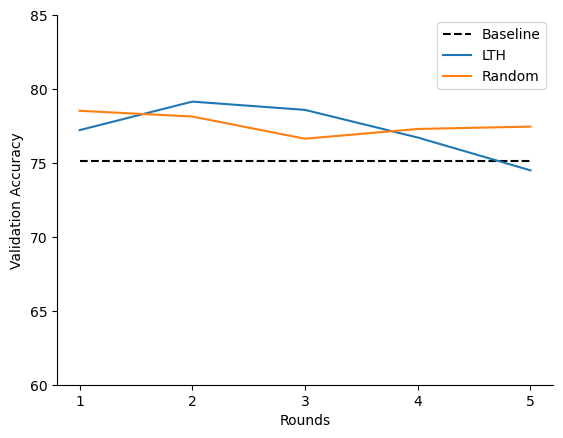

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=[1, 2, 3, 4, 5], y=[75.10, 75.10, 75.10, 75.10, 75.10], linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[1, 2, 3, 4, 5], y=[77.22, 79.15, 78.59, 76.72, 74.50], label="LTH")
sns.lineplot(x=[1, 2, 3, 4, 5], y=[78.53, 78.14, 76.64, 77.30, 77.46], label="Random")
plt.ylim(60, 85)
plt.xticks((1, 2, 3, 4, 5))
plt.xlabel("Rounds")
plt.ylabel("Validation Accuracy")
sns.despine()

### Run an experiment wherein, instead of resetting the weights back to the initial weights after pruning, we initialize the weights **randomly**.

##### I am using xavier initialization

In [38]:
epochs = 2
rounds = 5
sparsity = 0.5
model = ConvNeuralNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for round_ in range(rounds):
    print("\n\n\nROUND", round_+1, "Started\n----------------------")
    model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
    if round_ == 0:
        print("Test Accuracy before pruning:", test_model(dataloader_val, device, model))
    else:
        print("Test Accuracy after pruning and retraining:", test_model(dataloader_val, device, model))
    with torch.no_grad():
        j = 0
        for i in range(len(model.layers)):
          if hasattr(model.layers[i], 'weight'):
              flatten_size = model.layers[i].weight.data.flatten().shape[0]
              # Lottery Ticket Style Pruning
              indices = torch.argsort(torch.reshape(torch.abs(model.layers[i].weight.data), (1, flatten_size)).squeeze())
              # Since we already have the indices to prune, let's re-initialize the weights randomly
              torch.nn.init.xavier_uniform_(model.layers[i].weight.data.unsqueeze(0))
              model.masks[j] = torch.reshape(model.masks[j], (1, flatten_size)).squeeze()
              val = ((sparsity*100)**((round_+1)/rounds))/100
              model.masks[j][indices[:math.ceil(val * flatten_size)]] = 0
              model.masks[j] = model.masks[j].view(*model.layers[i].weight.data.shape)
              j += 1
    print("Test Accuracy after pruning but no retraining:", test_model(dataloader_val, device, model))




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.6332860418728419 	Acc: 0.40958
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.1989059837497011 	Acc: 0.57178


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.5757


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.804520531576507 	Acc: 0.32344
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.336953273841313 	Acc: 0.51738


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.5292


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.8399499156037156 	Acc: 0.30658
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.292597732981857 	Acc: 0.53386


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.5693


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.79435687892291 	Acc: 0.31996
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.2465500539662886 	Acc: 0.55278


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.5486


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.8976688579637178 	Acc: 0.28394
Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 1.320467007403471 	Acc: 0.5228


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.5788


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.1


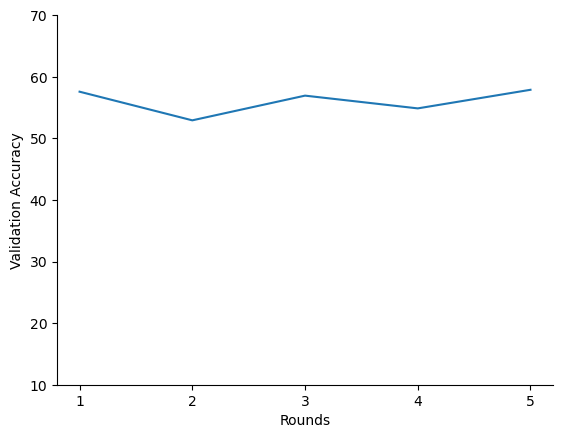

In [3]:
sns.lineplot(x=[1, 2, 3, 4, 5], y=[57.57, 52.92, 56.93, 54.86, 57.88])
plt.ylim(10, 70)
plt.xticks((1, 2, 3, 4, 5))
plt.xlabel("Rounds")
plt.ylabel("Validation Accuracy")
sns.despine()

We can see that the there is no significant change in accuracy if we randomly initialize the weights instead of setting it to the initial value. The accuracy just stays at around 57% because in every round its like the model is freshly getting trained.